In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from tqdm import tqdm

In [ ]:
# REFERENCE: https://www.carwow.co.uk/guides/glossary/what-is-a-car-wheelbase-0282
WHEEL_BASE = 2.43 #IN METERS

In [ ]:
f = open("/code/data/datasets/common_hall/tracking_outputs/framewise_aggregation.json")
frame_to_predictions_map = json.load(f)
f = open("/code/data/datasets/common_hall/tracking_outputs/objectwise_aggregation.json")
objects_to_predictions_map = json.load(f)['annotations'] #the object_id attribute of frame_to_predictions_map are the keys of object_to_predictions_map

In [ ]:
#get all the backtire keypoints for object 0
tire_dict = {}
for i in range(len(objects_to_predictions_map)):    
    tire_dict[f'obj_{i}_back_x'] = []
    tire_dict[f'obj_{i}_back_y'] = []
    tire_dict[f'obj_{i}_front_x'] = []
    tire_dict[f'obj_{i}_front_y'] = []
col_names = list(tire_dict.keys())

In [ ]:
def validate_inclusion(_x, _y, _cx, _cy, _r):
    return (_x - _cx)**2 + (_y -_cy)**2 < _r**2

In [ ]:
frame_path = '/code/data/datasets/frame_imgs'
frame_list = os.listdir(frame_path)
frame_border = True
rule0 = False
rule1 = False
rule2 = False
def get_objectwise_keypoints(rule0, rule1, rule2):
    objectwise_keypoints = {}
    for i in range(len(objects_to_predictions_map)):
        objectwise_keypoints[objects_to_predictions_map[i]['id']] = []
    for frame_idx in range(len(frame_to_predictions_map)):
        frame = cv2.imread(str(Path(frame_path)/f'{frame_idx}.jpg'))
        if frame_border:
            img = cv2.rectangle(frame, (450, 200), (1280, 720), (0, 255, 0), thickness=4)
        objects_per_frame = frame_to_predictions_map[frame_idx]['annotations']
        for obj_idx in range(len(objects_per_frame)):
            back_tire_x = objects_per_frame[obj_idx]['keypoints'][0][0]
            back_tire_y =objects_per_frame[obj_idx]['keypoints'][0][1]
            front_tire_x = objects_per_frame[obj_idx]['keypoints'][1][0]
            front_tire_y = objects_per_frame[obj_idx]['keypoints'][1][1]
            x1, y1, x2, y2 = objects_per_frame[obj_idx]['bounding_box']
            #rule #0
            if rule0 == True:
                frame_save_path = Path('/code/data/datasets/rule0_imgs')
                if x1 < 600 or x1>= 1100:
                    back_tire_x = -100
                    back_tire_y = -100
                    front_tire_x = -100
                    front_tire_y = -100

            #rule #1
            if rule1 == True:
                frame_save_path = Path('/code/data/datasets/rule1_imgs')
                if (back_tire_y <= y1 + int((y2 - y1)/2)):
                    back_tire_x = -100
                    back_tire_y = -100
                if (front_tire_y <= y1 + int((y2 - y1)/2)):
                    front_tire_x = -100
                    front_tire_y = -100
            #rule #2
            if rule2 == True:
                frame_save_path = Path('/code/data/datasets/rule2_imgs')
                if validate_inclusion(back_tire_x, back_tire_y, front_tire_x, front_tire_y, 20):
                    if np.array(objects_per_frame[obj_idx]['keypoints_scores']).argmax() == 0:
                        front_tire_x = -100
                        front_tire_y = -100
                    else:
                        back_tire_x = -100
                        back_tire_y = -100

            # img = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=4)
            # img = cv2.circle(img, (int(back_tire_x), int(back_tire_y)), radius=5, color=(0, 0, 255), thickness=-1) #Blue: Backtire
            # img = cv2.circle(img, (int(front_tire_x), int(front_tire_y)), radius=5, color=(255, 0, 0), thickness=-1) #Red Front tire
            # cv2.imwrite(os.path.join(frame_save_path, f'{frame_idx}.jpg'), img)
            # back_tire_x_list.append(back_tire_x)
            # back_tire_y_list.append(back_tire_y)
            # front_tire_x_list.append(front_tire_x)
            # front_tire_y_list.append(front_tire_y)
            objectwise_keypoints[objects_per_frame[obj_idx]['object_tracklet_id']].append((back_tire_x, back_tire_y, front_tire_x, front_tire_y))
    return objectwise_keypoints

In [ ]:
objectwise_keypoints = get_objectwise_keypoints(True, True, True)
object_names = list(objectwise_keypoints.keys())

In [ ]:
vehicle_keypoints = objectwise_keypoints[object_names[4]]

In [ ]:
object_name = object_names[4]
back_tire_x_list = []
back_tire_y_list = []
front_tire_x_list = []
front_tire_y_list = []
for keypoints_per_frame in objectwise_keypoints[object_name]:
    back_tire_x, back_tire_y, front_tire_x, front_tire_y = keypoints_per_frame
    back_tire_x_list.append(back_tire_x)
    back_tire_y_list.append(back_tire_y)
    front_tire_x_list.append(front_tire_x)
    front_tire_y_list.append(front_tire_y)

In [ ]:
back_tire_keypoints = [back_tire_x_list, back_tire_y_list]
back_tire_keypoints = [list(x) for x in zip(*back_tire_keypoints[::-1])]
front_tire_keypoints = [front_tire_x_list, front_tire_y_list]
front_tire_keypoints = [list(x) for x in zip(*front_tire_keypoints[::-1])]

In [ ]:
from math import sqrt
def get_distance(_x1, _y1, _x2, _y2):
    return sqrt((_x1 -_x2)**2 + (_y1 -_y2)**2)

In [ ]:
tire_distance = 0
valid_points = 0
total_num_points = len(objectwise_keypoints[object_name])
for keypoints_per_frame in objectwise_keypoints[object_name]:
    back_tire_x, back_tire_y, front_tire_x, front_tire_y = keypoints_per_frame
    if back_tire_x >=0 and front_tire_x >=0:
        valid_points += 1
        tire_distance += get_distance(back_tire_x, back_tire_y, front_tire_x, front_tire_y)
tire_distance /= valid_points
print("Tire Distance is ", tire_distance)
print("Num. of valid points are", valid_points)
print("Total number of points", total_num_points)


In [ ]:
def frames_to_seconds(_fps, _n_frames):
    return (1/_fps * _n_frames)

In [62]:
speed_checkpoints = []
vehicle_speed = []
for i in range(total_num_points):
    back_tire = back_tire_keypoints[i]
    if back_tire[0] < 0:
        continue
    for j in range(i,total_num_points):
        front_tire = front_tire_keypoints[j]
        if front_tire[0] < 0:
            continue
        back_tire_x = back_tire[0]
        back_tire_y = back_tire[1]
        front_tire_x = front_tire[0]
        front_tire_y = front_tire[1]
        if get_distance(back_tire_x, back_tire_y, front_tire_x, front_tire_y) >= tire_distance:
            # speed_checkpoints.append((i,j))
            speed_checkpoints.append((j - i))
            if (j -i) >= 5:
                approximate_speed = round(WHEEL_BASE / frames_to_seconds(30, j - i))
                print("Current Speed is", approximate_speed, "meters/Sec")
                vehicle_speed.append(approximate_speed)
            break
# print("Speed checkpoints are", speed_checkpoints)


Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 5 meters/Sec
Current Speed is 5 meters/Sec
Current Speed is 5 meters/Sec
Current Speed is 5 meters/Sec
Current Speed is 5 meters/Sec
Current Speed is 5 meters/Sec
Current Speed is 5 meters/Sec
Current Speed is 6 meters/Sec
Current Speed is 6 meters/Sec
Current Speed is 6 meters/Sec
Current Speed is 6 meters/Sec
Current Speed is 6 meters/Sec
Current Speed is 6 meters/Sec
Current Speed is 7 meters/Sec
Current Speed is 7 meters/Sec
Current Speed is 7 meters/Sec
Current Speed is 7 meters/Sec
Current Speed is 7 meters/Sec
Current Speed is 7 meters/Sec
Current Speed is 8 meters/Sec
Current Speed is 9 meters/Sec
Current Speed is 9 meters/Sec
Current Speed is 9 meters/Sec
Current Speed is 9 meters/Sec
Current Speed is 10 meters/Sec
Current Speed is 10 meters/Sec
Current Speed is 10 meters/Sec
Current Speed is 10 meters/Sec
Current Speed is 12 meters/Sec
Current Speed is 12 meters/Sec
Curr

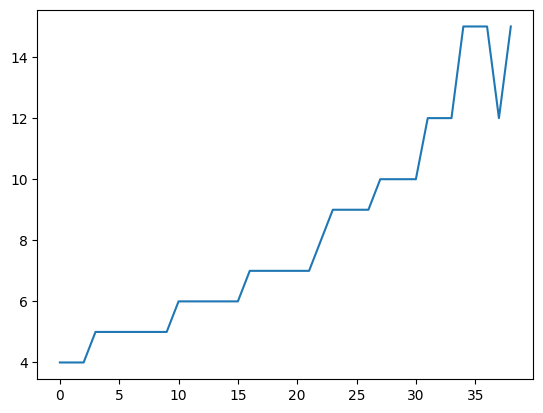

In [63]:
plt.plot(vehicle_speed)